In [1]:
# Check the files in Data
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from torch.utils.data import Dataset, DataLoader
import torch
import torchtext
# from transformers import BertTokenizer # assuming you want to use BERT tokenizer
import torch.nn as nn


In [2]:

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
# Import Data

data_folder = '/kaggle/input/nlp-getting-started/'

test = pd.read_csv(data_folder + 'test.csv')
train = pd.read_csv(data_folder + 'train.csv')
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
# to clean data
def normalise_text (text):
    text = text.str.lower() # lowercase
    text = text.str.replace(r"\#","") # replaces hashtags
    text = text.str.replace(r"http\S+","URL")  # remove URL addresses
    text = text.str.replace(r"@","")
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.str.replace("\s{2,}", " ")
    return text

In [5]:
# drop 'id' , 'keyword' and 'location' columns.
train.drop(columns=['id','keyword','location'], inplace=True)
train["text"]=normalise_text(train["text"])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [6]:
train.head()

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to 'shelter in place' are ...,1
3,13 000 people receive wildfires evacuation ord...,1
4,just got sent this photo from ruby alaska as s...,1


In [7]:
# split data into train and validation 
train_df, valid_df = train_test_split(train)


In [8]:
# tokenizer = torchtext.data.get_tokenizer("basic_english")

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.data = []
        for i, row in dataframe.iterrows():
            text, target = row['text'], row['target']
            self.data.append((text, int(target)))
            self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, target = self.data[idx]
        inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=76, return_tensors='pt')
        inputs_ids = inputs['input_ids'].squeeze(0)
        attention_masks = inputs['attention_mask'].squeeze(0)
        return inputs_ids, attention_masks, target 

Determine the maximum length of the sentence 

In [9]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained('roberta-base') # or any other tokenizer
sentences = train["text"]
sentences_tokenized = [tokenizer.tokenize(sentence) for sentence in sentences ]
# tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence0))
# print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [10]:
print('Max sentence length: ', max([len(sen) for sen in sentences_tokenized]))

Max sentence length:  48


In [11]:
train_dataset = CustomDataset(train_df, tokenizer)
val_dataset = CustomDataset(valid_df, tokenizer)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
# inputs_ids, attention_masks, label = next(iter(train_dataloader))
# print(label.shape)


In [12]:
from transformers import AdamW, RobertaConfig

In [13]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base', # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# model that we keep for validation
best_model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base', # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [14]:
# Define the device to run the model on (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# Tell pytorch to run this model on the GPU.
model = model.to(device)

In [16]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias           (

Optimizer

In [17]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW (model.parameters(),
                  lr =1e-6, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                  weight_decay=0.05
                )

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [18]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 50
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


Create function to calculate accuracy 

In [19]:
import numpy as np
from torch.nn import functional as F

def compute_acc(preds, labels):
    correct = 0
    preds_ = preds.data.max(1)[1]
    correct = preds_.eq(labels.data).cpu().sum()
    acc = float(correct) / float(len(labels.data)) * 100.0
    return acc


In [20]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [21]:
# for param in model.base_model.parameters():
#     param.requires_grad = False

In [22]:
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Validation Loss')
    axs[0].set_title("Losses over Epochs")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    
    axs[1].plot(train_accuracies, label='Train Accuracy')
    axs[1].plot(val_accuracies, label='Validation Accuracy')
    axs[1].set_title("Accuracies over Epochs")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    
    plt.tight_layout()
#     plt.savefig(path)


In [23]:
patience = 4 
num_no_improvement = 0 

# Store the average loss after each epoch so we can plot them.
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
show_every = 20

# Keep track of the best validation loss
best_val_loss = float('inf')


# For each epoch...
for epoch_i in range(0, epochs):
    
    store_train_loss = []
    store_train_acc = []
    store_val_loss = []
    store_val_acc = []
    
     # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    
    model.train()
    
    
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        inputs_ids, attention_masks, labels = batch
        model.zero_grad()
        
        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(inputs_ids, 
                    attention_mask=attention_masks)
        
#         print(outputs[0])
#         print(labels.shape)
#         print(outputs[0].shape)
        loss = F.cross_entropy(outputs[0], labels)
#         print(outputs.shape)
        
        train_acc = compute_acc(outputs[0], labels)

        # Print the statistics
        store_train_loss.append(loss.item())
        store_train_acc.append(train_acc)
        
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
        
        # Progress update every 40 batches.
        if step % show_every == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {} / {}.  Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            print('Training loss: %.3f  Training acc: %.3f'%(np.mean(store_train_loss[-show_every:]), np.mean(store_train_acc[-show_every:])) ) 
    
        
    # compute epoch loss and accuracy 
    train_losses.append(np.mean(store_train_loss))
    train_accuracies.append(np.mean(store_train_acc))
    
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
    
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    
    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        val_inputs_ids, val_attention_masks, val_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():  
            val_outputs = model(val_inputs_ids,  
                            attention_mask=val_attention_masks)
            
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        val_logits = val_outputs[0]
        
        val_loss = F.cross_entropy(val_logits, val_labels)
        
        # Calculate the accuracy for this batch of test sentences.
        val_acc = compute_acc(val_logits, val_labels)
        
        store_val_loss.append(val_loss.item())
        store_val_acc.append(val_acc)
        
    
    # compute epoch loss and accuracy 
    mean_val_loss = np.mean(store_val_loss)
    val_losses.append(mean_val_loss)
    val_accuracies.append(np.mean(store_val_acc))
        
    # Report the final accuracy for this validation run.
    # Print loss and acc at the end of the epoch
    print("Epoch {}: Train Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%".format
    (epoch_i, train_losses[-1], val_losses[-1], train_accuracies[-1], val_accuracies[-1]))
    


    #Check if validation loss has improved
    if np.mean(mean_val_loss < best_val_loss):
        best_val_loss = mean_val_loss
        # Get the current state of the model
        model_state_dict = model.state_dict()
        best_model.load_state_dict(model_state_dict)
        num_no_improvement = 0 
    else:
        num_no_improvement+=1 
    if num_no_improvement == patience: 
        break

        
print("")
print("Training complete!")
    


======== Epoch 1 / 50 ========
Training...
  Batch 20 / 179.  Elapsed: 0:00:11.
Training loss: 0.707  Training acc: 43.906
  Batch 40 / 179.  Elapsed: 0:00:18.
Training loss: 0.699  Training acc: 46.094
  Batch 60 / 179.  Elapsed: 0:00:26.
Training loss: 0.693  Training acc: 49.219
  Batch 80 / 179.  Elapsed: 0:00:33.
Training loss: 0.694  Training acc: 51.094
  Batch 100 / 179.  Elapsed: 0:00:41.
Training loss: 0.691  Training acc: 54.531
  Batch 120 / 179.  Elapsed: 0:00:48.
Training loss: 0.684  Training acc: 60.156
  Batch 140 / 179.  Elapsed: 0:00:56.
Training loss: 0.674  Training acc: 60.781
  Batch 160 / 179.  Elapsed: 0:01:04.
Training loss: 0.663  Training acc: 59.688
  Training epoch took: 0:01:10

Running Validation...
Epoch 0: Train Loss: 0.6851, Validation Loss: 0.6383, Train Accuracy: 53.30%, Validation Accuracy: 58.91%

======== Epoch 2 / 50 ========
Training...
  Batch 20 / 179.  Elapsed: 0:00:08.
Training loss: 0.619  Training acc: 69.688
  Batch 40 / 179.  Elapsed: 

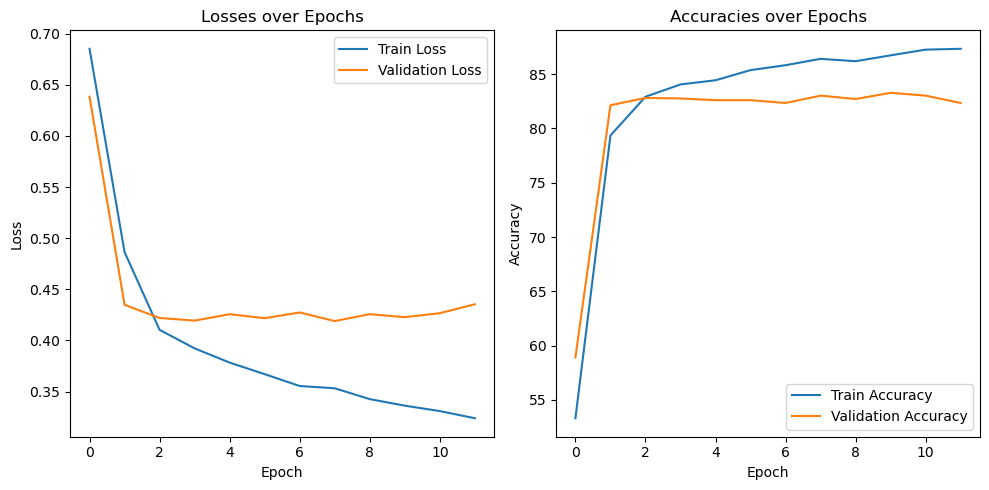

In [24]:
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)

In [25]:
test = pd.read_csv(data_folder + 'test.csv')

test.drop(columns=['keyword','location'], inplace=True)

test["text"]=normalise_text(test["text"])

test['target'] = 0

test_dataset = CustomDataset(test, tokenizer)
batch_size = 8
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [26]:

# Load the state dictionary into the model

# Set the model to evaluation mode
best_model.to(device)
best_model.eval()


store_test_acc = []

store_predictions = torch.zeros(len(test_dataset), dtype=torch.int)

# For each batch of training data...
for step, batch in enumerate(test_dataloader):
    
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    inputs_ids, attention_masks, labels = batch
    with torch.no_grad():
        outputs = best_model(inputs_ids, 
                    token_type_ids=None, 
                    attention_mask=attention_masks)
        predictions = torch.max(outputs[0], dim=1)[1]
        store_predictions[step*len(predictions): (step+1)*len(predictions)] = predictions
        # store_test_acc.append(compute_acc(outputs[0], labels))


store_predictions = store_predictions.detach().cpu().numpy()

test['target'] = store_predictions

test.drop(columns=['text'], inplace=True)

test.to_csv('submission.csv', index=False)


print("Finished testing")

Finished testing


In [27]:
test.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,0
